In [1]:
# imports
import torch
from torch import nn
from torchvision.models import resnet18
from torch.utils.data import Dataset
from torchvision import datasets
from torch.utils.data import DataLoader
import torch.nn.functional as F
import platform
from torch.autograd import Variable
import time
from efficientnet_pytorch import EfficientNet
import glob
import os
from sklearn import metrics
import gc
from torchvision.ops import focal_loss
import json
# vis
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import sklearn.metrics
from math import ceil
import cv2
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import PIL
import seaborn as sns

# Albumenatations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2, ToTensor

# Setup

In [2]:
# import dataset
id_s = pd.read_csv('../input/id_s.csv')

In [3]:
class Config:
    train_pcent = 0.8
    TRAIN_BS = 1 #rip gpu
    VALID_BS = 1 # rip gpu
    NB_EPOCHS = 20
    model_name = 'EfficientNETB2'
    reshape_size = (800, 800)
    num_classes = 4
    seed = 69
    val_fold = 4
    save_path = 'C:\\Users\\Admin\\Git\\SIIM\\models\\EfficientNETB2\\'

In [4]:
config_dict = {attribute: value for attribute, value in Config.__dict__.items() if '__' not in attribute }

In [5]:
train_ids = id_s[id_s.fold!=Config.val_fold].id.values
valid_ids = id_s[id_s.fold==Config.val_fold].id.values

In [6]:
mapping = {0: 'Negative for Pneumonia',
1: 'Typical Appearance',
2: 'Indeterminate Appearance',
3: 'Atypical Appearance'}

# Transformations

In [7]:
train_transform = A.Compose([
        A.HorizontalFlip(p=0.5), 
        A.VerticalFlip(p=0.5),
        A.OneOf([A.RandomBrightnessContrast(brightness_limit=0.4,
                                  contrast_limit=0.4, p=0.3),
                 A.RandomGamma(gamma_limit=(50, 300), eps=None, always_apply=False, 
                      p=0.3),
            ], p=0.2),
        A.Resize(height=Config.reshape_size[0], width=Config.reshape_size[1], 
                 p=1.0),
        ToTensorV2(p=1.0)])

valid_transform = A.Compose([A.Resize(height=Config.reshape_size[0], 
                                      width=Config.reshape_size[1], p=1.0),
                             ToTensorV2(p=1.0)])

# Dataset

In [8]:
class SIIM(Dataset):
    def __init__(self, image_ids, df, transforms=None):
        super().__init__()
        # image_ids
        self.image_ids = image_ids
        # random sample data
        self.df = df
        # augmentations
        self.transforms = transforms
    
    def __len__(self) -> int:
        return(len(self.image_ids))
    
    @staticmethod
    def dicom2array(path: str, voi_lut=True, fix_monochrome=True):
        dicom = pydicom.read_file(path)
        # VOI LUT (if available by DICOM device) is used to
        # transform raw DICOM data to "human-friendly" view
        if voi_lut:
            data = apply_voi_lut(dicom.pixel_array, dicom)
        else:
            data = dicom.pixel_array
        # depending on this value, X-ray may look inverted - fix that:
        if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
            data = np.amax(data) - data
        data = data - np.min(data)
        data = data / np.max(data)
        return data.astype(np.float32)
    
    def load_labels(self, image_id):
        # find row
        records = self.df[self.df['id'] == image_id]
        # get label
        labels = records[[mapping[0], mapping[1], mapping[2], mapping[3]]].values[0]
        #label = records['integer_label'].values[0] # only one label per image
        return(labels)
    
    def __getitem__(self, idx: int):
        # retrieve idx data
        image_id = self.image_ids[idx]
        # get path
        image_path = self.df[self.df['id'] == image_id].file_path.values[0]
        # get image
        image = self.dicom2array(image_path)
        # get labels
        labels = self.load_labels(image_id)
        # Augments
        if self.transforms:
            t = self.transforms(**{'image': image})
            image = t['image']

        return image, labels, image_id

## Test Dataset

In [9]:
def show_one(image, target):
    print(target)
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    image = image.squeeze(0).numpy()
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.bone)
    plt.show()

In [10]:
test = SIIM(image_ids=train_ids, df=id_s, transforms=valid_transform)

In [11]:
image, labels, idx = test[0]

[0 1 0 0]


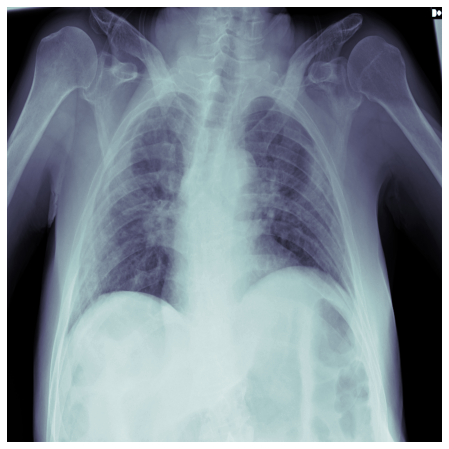

In [12]:
show_one(image, labels)

# Dataloader and Collate Function

In [13]:
def collate_fn(batch):
    images, targets, idx = tuple(zip(*batch))
    return(tuple((torch.stack(images).float(), targets, idx)))

In [14]:
test_loader = DataLoader(
    test,
    batch_size=Config.TRAIN_BS,
    shuffle=True)

In [15]:
image, labels, idx = next(iter(test_loader))

In [16]:
image.shape

torch.Size([1, 1, 800, 800])

In [17]:
labels.shape

torch.Size([1, 4])

# Model

This is multi-class classification problem. There are many labels that the image could be, however the image can't hold more than one label. Normally that would mean softmax with cross entropy. However Focal loss is normally used with sigmoid.

In [18]:
class EfficientNETB2(nn.Module):
    def __init__(self, NUM_CLASSES=Config.num_classes, pretrained=True):
        super(EfficientNETB2, self).__init__()
        # model
        self.NUM_CLASSES = NUM_CLASSES
        self.effnet = self.load_effnet(pretrained)
        self.effnet._conv_stem = nn.Conv2d(in_channels=1, out_channels=32, 
                                           kernel_size=(3, 3), stride=(2, 2), bias=False)
        self.effnet._fc = nn.Linear(1408, self.NUM_CLASSES)
        self.out = nn.Sigmoid()
        
    def load_effnet(self, pretrained):
        if pretrained == True:
            effnet = EfficientNet.from_pretrained("efficientnet-b2")
        else:
            effnet = EfficientNet.from_name("efficientnet-b2")
        return effnet
        
    def forward(self, X):
        X = self.effnet(X)
        output = self.out(X)
        return(output)

# Loss Function

The output of the model is currently of Softmax type. Currently no implementation of focal loss, although this is the goal.

We will use cross entropy loss.

## Focal Loss

<code>f_loss = focal_loss.sigmoid_focal_loss(out, labels.float())
out->tensor([[0.0158, 0.2808, 0.2882, 0.2775],
    [0.2780, 0.2959, 0.0170, 0.2726]], grad_fn=MulBackward0)</code>

Focal loss returns the loss for individual classes, we can choose how to deal with the loss individually or reduce the loss to 'sum' or mean'. The original paper sums the losses, so we will do the same.

<code>f_loss = focal_loss.sigmoid_focal_loss(out, labels.float(), reduction='sum')
    out -> tensor(1.7259, grad_fn=SumBackward0)</code>

In [19]:
"https://www.kaggle.com/bigironsphere/loss-function-library-keras-pytorch"
class FocalLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(FocalLoss, self).__init__()

    def forward(self, inputs, targets, alpha=2.0, gamma=0.25, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        #inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #first compute binary cross-entropy 
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        BCE_EXP = torch.exp(-BCE)
        focal_loss = alpha * (1-BCE_EXP)**gamma * BCE
                       
        return focal_loss

# Logging

In [20]:
class Logman(object):
    """
    Json data should save as follows:
    
    {'type': hyper, 'model':?, 'optim': ?, 'model': ?, 'train_len': ?, 'val_len': ?, 'device': ? ...etc...}

    {'type': train, 'epoch': num, 'batch': num, 'loss': num, ...etc...}

    {'type': val, 'epoch': num, 'batch': num, 'loss': num, 'metric': num ...etc...}
    {'type': 'val_metric', 'epoch': epoch, 'accuracy': accuracy, 'recall': recall, 'precision': precision, 'f1_score': f1_score}

    {'type': final, 'epochs': num, 'batches': num, 'final_loss': num, 'final_metric': num ...etc...}
    
    """
    def __init__(self, hyper, save_path='./', save_name='logs'):
        #load
        self.hyper = hyper
        self.save_path = save_path
        self.save_name = save_name
        # assertions
        assert self.hyper['type'] == 'hyper'
        assert self.hyper['model']
        # init store
        self.store = {'model': self.hyper['model']}
        self.store.update({k: v for k, v in self.hyper.items() if (k != 'type' and k != 'model')})
        self.store['data'] = []
        # save empty logs
        self.save_logs()
        
    def save_logs(self):
        """
        The current implementation does not append or concatenate current file
        but instead save on top of current file with large dictionary.
        """
        with open(os.path.join(self.save_path, self.save_name)+'.json','w') as file:
            json.dump(self.store, file, indent = 4)
            file.close()
            
    def log(self, data):
        """
        Takes in any input data of form dict.
        Handles data by key 'type'.
        Sends to relevant method.
        """
        if data:
            # first log
            if not self.store['data']:
                self.store['data'] = [data]
            else:
                # check for final
                if data['type'] == 'final':
                    self.finalise(data)
                else:
                    # append data to data key in store
                    self.store['data'].append(data)
        else:
            # error
            self.store['data'].append({'type': 'error', 'reason': 'No data present'})
    
    def finalise(self, data):
        """
        Finalise logs, send final parameters to dict.
        Save logs
        """
        self.store.update({k: v for k, v in data.items() if (k != 'type' and k != 'model')})
        self.save_logs()

# Trainer

In [21]:
def evals(true, preds):
    # convert with threshold
    tp, tn, fp, fn = 0, 0, 0, 0
    for t, p in zip(true, preds):
        pred = (p>0.5).astype(int)
        tp += (t * pred).sum().astype(np.float32)
        tn += ((1 - t) * (1 - p)).sum().astype(np.float32)
        fp += ((1 - t) * p).sum().astype(np.float32)
        fn += (t * (1 - p)).sum().astype(np.float32)
        
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    recall = (tp) / (tp + fn)
    precision = (tp) / (tp + fp)
    f1_score = (2*tp) / (2*tp + fp + fn)
    return(accuracy, recall, precision, f1_score)

In [22]:
class Trainer:
    def __init__(self, train_dataloader, valid_dataloader, model, loss,
                optimiser, lr_scheduler=None, logger=None, device='cpu'):
        """
        Constructor for Trainer class
        """
        self.train = train_dataloader
        self.valid = valid_dataloader
        self.model = model
        self.loss = loss
        self.optim = optimiser
        self.lr_scheduler = lr_scheduler
        self.logger = logger
        self.device = device
        
    def train_one_cycle(self, epoch):
        """
        Run one epoch of training, backpropogation and optimisation.
        """        
        # model train mode
        self.model.train()
        
        # progress bar
        train_prog_bar = tqdm(self.train, total=len(self.train))
        
        # stats
        all_train_labels = []
        all_train_preds = []
        running_loss = 0
        
        with torch.set_grad_enabled(True):
            for batch_num, (images, labels, idx) in enumerate(train_prog_bar):
                # zero gradient optim
                self.optim.zero_grad()
                
                # send to devices
                images = images.to(self.device)
                labels = labels.to(self.device)
                
                # get outputs
                out = self.model(images)
                
                # loss fn
                train_loss = self.loss(out, labels.float())

                # Backpropogation
                train_loss.backward()
                self.optim.step()
                
                # For averaging and reporting later
                running_loss += train_loss.item()
                
                # logging
                if self.logger:
                    self.logger.log({'type': 'train', 
                                     'epoch': epoch, 
                                     'batch': batch_num, 
                                     'loss': train_loss.item()
                                    })
                    
                # show the current loss to the progress bar
                train_pbar_desc = f'loss: {train_loss.item():.4f}'
                train_prog_bar.set_description(desc=train_pbar_desc)
                
            # average the running loss over all batches and return
            train_running_loss = running_loss / len(self.train)
            print(f"Final Training Loss: {train_running_loss:.4f}")

            # free memory
            del images, labels, train_loss
            # free up cache
            torch.cuda.empty_cache()
            return(train_running_loss)
        

    def valid_one_cycle(self, epoch):
        """
        Runs one epoch of prediction.
        In model.train() mode, model(images)  is returning losses.
        We are using model.eval() mode --> it will return boxes and scores. 
        """        
        self.model.eval()
        
        valid_prog_bar = tqdm(self.valid, total=len(self.valid))
        with torch.no_grad():
            
            all_valid_labels = []
            all_valid_preds = []
            
            running_loss = 0

            for batch_num, (images, labels, idx) in enumerate(valid_prog_bar):
                # send to devices
                images = images.to(self.device)
                labels = labels.to(self.device)
                # get predictions
                out = self.model(images)
                # loss fn
                # loss fn
                val_loss = self.loss(out, labels.float())
                running_loss += val_loss.item()
                
                all_valid_labels += [out.flatten().detach().cpu().numpy()]
                all_valid_preds += [labels.flatten().detach().cpu().numpy()]
                    
                # logging
                if self.logger:
                    self.logger.log({'type': 'val', 
                                     'epoch': epoch, 
                                     'batch': batch_num, 
                                     'loss': val_loss.item()})
                        
                # Show the current metric
                valid_pbar_desc = f"Valid Loss: {val_loss:.4f}"
                valid_prog_bar.set_description(desc=valid_pbar_desc)
            
            accuracy, recall, precision, f1_score = evals(all_valid_labels, all_valid_preds)
            # logging
            if self.logger:
                self.logger.log({'type': 'val_metric', 
                                 'epoch': epoch, 
                                 'accuracy': accuracy,
                                 'recall': recall,
                                 'precision': precision,
                                 'f1_score': f1_score})
            # Get the final loss
            final_loss_val = running_loss / len(self.valid)
            print(f"Validation loss: {final_loss_val:.4f}")
            # Free up memory
            del images, out, labels, accuracy, recall, precision, f1_score
            
            torch.cuda.empty_cache()

            return (final_loss_val, model)
        
    def adjust(self):
        # learning rate
        if self.lr_scheduler:
            self.lr_scheduler.step()

In [23]:
# clear stuff
gc.collect()
torch.cuda.empty_cache()

In [24]:
# Training Cycle
nb_training_samples = len(train_ids)
nb_valid_samples = len(valid_ids)
print(f"[INFO] Training on {len(train_ids)} samples ({int(Config.train_pcent*100)}%) and validation on {nb_valid_samples} ({ceil(abs(1 - Config.train_pcent) * 100)}%) samples")

if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))
        DEVICE = torch.device('cuda:0')
else:
    print("\n[INFO] GPU not found. Using CPU: {}\n".format(platform.processor()))
    DEVICE = torch.device('cpu')
################################################################################################################################        

# Make Training and Validation Datasets
training_set = SIIM(image_ids=train_ids, 
               df=id_s, transforms=train_transform)

validation_set = SIIM(image_ids=valid_ids, 
               df=id_s, transforms=valid_transform)

train_loader = DataLoader(
    training_set,
    batch_size=Config.TRAIN_BS,
    shuffle=True)

valid_loader = DataLoader(
    validation_set,
    batch_size=Config.VALID_BS,
    shuffle=False)
################################################################################################################################        
if "EfficientNETB2" in Config.model_name in Config.model_name:        
    model = EfficientNETB2(pretrained=True).to(DEVICE)
    
else:
    raise RuntimeError("Must specify a valid model type to train.")

print(f"Training Model: {Config.model_name}")

optim = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
optim_name = 'SGD'
lr_scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=4, gamma=0.1)
sched_name = 'StepLR'
loss_fn = FocalLoss()
loss_name = 'Focal Loss'
################################################################################################################################        
params = {'type': 'hyper',
          'model': Config.model_name,
          'optim': optim_name,
          'loss': loss_name,
          'scheduler': sched_name,
          'train_samples': nb_training_samples, 
          'val_samples': nb_valid_samples, 
          'device': torch.cuda.get_device_name()}
params.update(config_dict)
hyper_params = params
print(f'Config: {hyper_params}')
logman = Logman(hyper_params, Config.save_path, Config.model_name)
################################################################################################################################        

trainer = Trainer(
    train_dataloader=train_loader,
    valid_dataloader=valid_loader,
    model=model,
    loss = loss_fn,
    optimiser=optim,
    lr_scheduler=lr_scheduler,
    logger=logman,
    device=DEVICE
)
################################################################################################################################        

train_losses_eff = []
valid_losses_eff = []


for epoch in range(Config.NB_EPOCHS):
    # Empty CUDA cache
    torch.cuda.empty_cache()
    print(f"{'-'*20} EPOCH: {epoch+1}/{Config.NB_EPOCHS} {'-'*20}")

    # Run one training epoch
    current_train_loss = trainer.train_one_cycle(epoch)
    train_losses_eff.append(current_train_loss)

    # Run one validation epoch
    current_val_loss, op_model = trainer.valid_one_cycle(epoch)
    valid_losses_eff.append(current_val_loss)

    # learning_rate
    trainer.adjust()
        
    # save model
    op_model.eval()
    torch.save({
        'model_state_dict': op_model.state_dict(), #'model_state_dict': self.model.model.state_dict(),
        'optimizer_state_dict': optim.state_dict(),
        'scheduler_state_dict': lr_scheduler.state_dict(),
        'train_loss': current_train_loss,
        'val_loss': current_val_loss,
        'epoch': epoch,
        
    }, Config.save_path+'epoch_{epoch}.pth'.format(epoch=epoch))

logman.log({'type': 'final', 
            'final_train_loss': current_train_loss, 
            'final_val_loss': current_val_loss})

[INFO] Training on 4874 samples (80%) and validation on 1218 (20%) samples
[INFO] Using GPU: GeForce GTX 970

Loaded pretrained weights for efficientnet-b2


  0%|                                                                       | 0/4874 [00:00<?, ?it/s]

Training Model: EfficientNETB2
Config: {'type': 'hyper', 'model': 'EfficientNETB2', 'optim': 'SGD', 'loss': 'Focal Loss', 'scheduler': 'StepLR', 'train_samples': 4874, 'val_samples': 1218, 'device': 'GeForce GTX 970', 'train_pcent': 0.8, 'TRAIN_BS': 1, 'VALID_BS': 1, 'NB_EPOCHS': 20, 'model_name': 'EfficientNETB2', 'reshape_size': (800, 800), 'num_classes': 4, 'seed': 69, 'val_fold': 4, 'save_path': 'C:\\Users\\Admin\\Git\\SIIM\\models\\EfficientNETB2\\'}
-------------------- EPOCH: 1/20 --------------------


Valid Loss: 1.1564:   0%|                                           | 1/1218 [00:00<03:22,  6.02it/s]

Final Training Loss: 0.7827


Valid Loss: 0.7568:   2%|▋                                         | 20/1218 [00:03<03:38,  5.49it/s]C:\Users\Admin\miniconda3\envs\cell\lib\site-packages\pydicom\pixel_data_handlers\numpy_handler.py:341: UserWarning: The length of the pixel data in the dataset (13262360 bytes) indicates it contains excess padding. 216296 bytes will be removed from the end of the data
  warnings.warn(msg)
  0%|                                                                       | 0/4874 [00:00<?, ?it/s]

Validation loss: 0.9797
-------------------- EPOCH: 2/20 --------------------


Valid Loss: 0.7004:   0%|                                           | 1/1218 [00:00<03:09,  6.43it/s]

Final Training Loss: 0.6991


  0%|                                                                       | 0/4874 [00:00<?, ?it/s]

Validation loss: 1.0605
-------------------- EPOCH: 3/20 --------------------


Valid Loss: 1.0180:   0%|                                           | 1/1218 [00:00<03:18,  6.14it/s]

Final Training Loss: 0.6760


  0%|                                                                       | 0/4874 [00:00<?, ?it/s]

Validation loss: 0.8960
-------------------- EPOCH: 4/20 --------------------


Valid Loss: 0.5374:   0%|                                           | 1/1218 [00:00<03:22,  6.00it/s]

Final Training Loss: 0.6669


  0%|                                                                       | 0/4874 [00:00<?, ?it/s]

Validation loss: 0.8972
-------------------- EPOCH: 5/20 --------------------


Valid Loss: 0.5054:   0%|                                           | 1/1218 [00:00<03:15,  6.23it/s]

Final Training Loss: 0.6102


  0%|                                                                       | 0/4874 [00:00<?, ?it/s]

Validation loss: 0.8185
-------------------- EPOCH: 6/20 --------------------


Valid Loss: 1.0157:   0%|                                           | 1/1218 [00:00<03:10,  6.39it/s]

Final Training Loss: 0.5983


  0%|                                                                       | 0/4874 [00:00<?, ?it/s]

Validation loss: 0.7974
-------------------- EPOCH: 7/20 --------------------


Valid Loss: 0.9912:   0%|                                           | 1/1218 [00:00<03:13,  6.29it/s]

Final Training Loss: 0.5902


  0%|                                                                       | 0/4874 [00:00<?, ?it/s]

Validation loss: 0.8141
-------------------- EPOCH: 8/20 --------------------


Valid Loss: 1.0171:   0%|                                           | 1/1218 [00:00<03:09,  6.43it/s]

Final Training Loss: 0.5810


  0%|                                                                       | 0/4874 [00:00<?, ?it/s]

Validation loss: 0.8303
-------------------- EPOCH: 9/20 --------------------


Valid Loss: 0.5489:   0%|                                           | 1/1218 [00:00<03:22,  6.00it/s]

Final Training Loss: 0.5668


  0%|                                                                       | 0/4874 [00:00<?, ?it/s]

Validation loss: 0.8334
-------------------- EPOCH: 10/20 --------------------


Valid Loss: 0.7446:   0%|                                           | 1/1218 [00:00<03:11,  6.35it/s]

Final Training Loss: 0.5589


  0%|                                                                       | 0/4874 [00:00<?, ?it/s]

Validation loss: 0.8077
-------------------- EPOCH: 11/20 --------------------


Valid Loss: 0.6537:   0%|                                           | 1/1218 [00:00<03:18,  6.13it/s]

Final Training Loss: 0.5547


  0%|                                                                       | 0/4874 [00:00<?, ?it/s]

Validation loss: 0.8149
-------------------- EPOCH: 12/20 --------------------


Valid Loss: 0.4781:   0%|                                           | 1/1218 [00:00<03:14,  6.27it/s]

Final Training Loss: 0.5522


  0%|                                                                       | 0/4874 [00:00<?, ?it/s]

Validation loss: 0.8227
-------------------- EPOCH: 13/20 --------------------


Valid Loss: 0.5793:   0%|                                           | 1/1218 [00:00<03:14,  6.27it/s]

Final Training Loss: 0.5526


  0%|                                                                       | 0/4874 [00:00<?, ?it/s]

Validation loss: 0.8171
-------------------- EPOCH: 14/20 --------------------


Valid Loss: 0.5958:   0%|                                           | 1/1218 [00:00<03:15,  6.22it/s]

Final Training Loss: 0.5540


  0%|                                                                       | 0/4874 [00:00<?, ?it/s]

Validation loss: 0.8116
-------------------- EPOCH: 15/20 --------------------


Valid Loss: 0.6256:   0%|                                           | 1/1218 [00:00<03:09,  6.41it/s]

Final Training Loss: 0.5491


  0%|                                                                       | 0/4874 [00:00<?, ?it/s]

Validation loss: 0.8219
-------------------- EPOCH: 16/20 --------------------


Valid Loss: 0.6712:   0%|                                           | 1/1218 [00:00<03:06,  6.53it/s]

Final Training Loss: 0.5515


  0%|                                                                       | 0/4874 [00:00<?, ?it/s]

Validation loss: 0.8077
-------------------- EPOCH: 17/20 --------------------


Valid Loss: 0.7371:   0%|                                           | 1/1218 [00:00<03:10,  6.37it/s]

Final Training Loss: 0.5470


  0%|                                                                       | 0/4874 [00:00<?, ?it/s]

Validation loss: 0.8049
-------------------- EPOCH: 18/20 --------------------


Valid Loss: 0.5460:   0%|                                           | 1/1218 [00:00<03:16,  6.20it/s]

Final Training Loss: 0.5484


  0%|                                                                       | 0/4874 [00:00<?, ?it/s]

Validation loss: 0.8094
-------------------- EPOCH: 19/20 --------------------


Valid Loss: 0.5183:   0%|                                           | 1/1218 [00:00<03:13,  6.30it/s]

Final Training Loss: 0.5511


  0%|                                                                       | 0/4874 [00:00<?, ?it/s]

Validation loss: 0.8295
-------------------- EPOCH: 20/20 --------------------


Valid Loss: 0.4750:   0%|                                           | 1/1218 [00:00<03:16,  6.19it/s]

Final Training Loss: 0.5518


Valid Loss: 0.1005: 100%|████████████████████████████████████████| 1218/1218 [06:02<00:00,  3.36it/s]


Validation loss: 0.8371


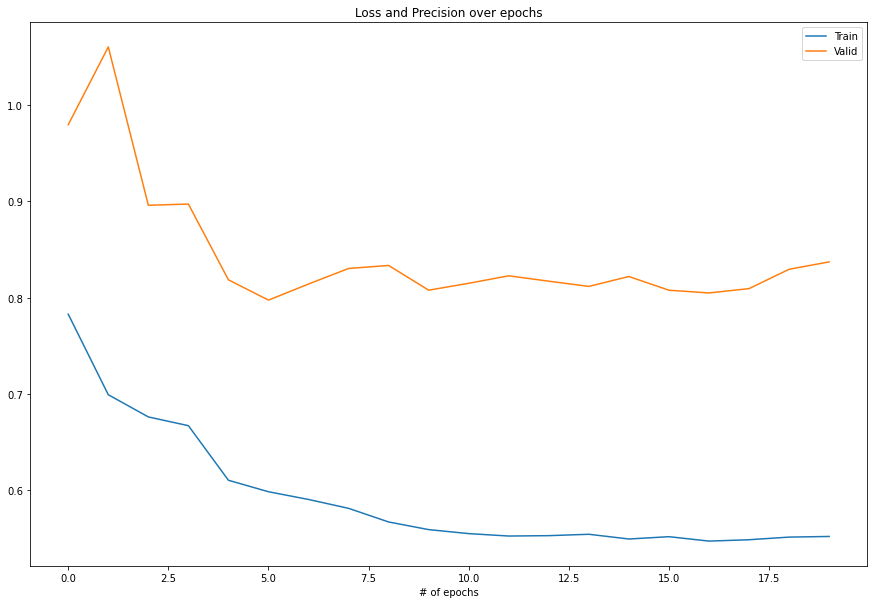

In [25]:
fig, ax = plt.subplots(1, 1, sharex = True, figsize=(15, 10))
ax.plot(np.arange(0, len(train_losses_eff), 1), train_losses_eff, label='Train')
ax.plot(np.arange(0, len(valid_losses_eff), 1), valid_losses_eff, label='Valid')
ax.set_xlabel('# of epochs')
ax.legend()
ax.set_title('Loss and Precision over epochs')
plt.show()

# Inference

In [26]:
with open(os.path.join(Config.save_path, Config.model_name)+'.json', 'r') as file:
    data = file.read()
    file.close()

obj = json.loads(data)

In [27]:
print(obj.keys())

dict_keys(['model', 'optim', 'loss', 'scheduler', 'train_samples', 'val_samples', 'device', 'train_pcent', 'TRAIN_BS', 'VALID_BS', 'NB_EPOCHS', 'model_name', 'reshape_size', 'num_classes', 'seed', 'val_fold', 'save_path', 'data', 'final_train_loss', 'final_val_loss'])


In [28]:
# load df
train_df = pd.DataFrame([row for row in obj['data'] if row['type'] == 'train'])
valid_df = pd.DataFrame([row for row in obj['data'] if row['type'] == 'val'])
metric_df = pd.DataFrame([row for row in obj['data'] if row['type'] == 'val_metric'])

In [29]:
# plus one for each epoch and batch
train_df['epoch'] += 1
train_df['batch'] += 1
valid_df['epoch'] += 1
valid_df['batch'] += 1
metric_df['epoch'] += 1

In [30]:
c_train = train_df.copy()
c_train['iteration'] = c_train.index + 1
c_train['cum_loss'] = c_train.loss.cumsum()
c_train['cum_loss_epoch'] = c_train.groupby('epoch')['loss'].cumsum()
c_train['avg_loss_epoch'] = c_train.cum_loss_epoch / c_train.batch
c_train['avg_loss'] = c_train.cum_loss / c_train.iteration
c_train.set_index(['epoch', 'batch'])

type      loss  iteration      cum_loss  cum_loss_epoch  \
epoch batch                                                             
1     1      train  1.158529          1      1.158529        1.158529   
      2      train  1.139995          2      2.298524        2.298524   
      3      train  1.191575          3      3.490098        3.490098   
      4      train  1.153847          4      4.643945        4.643945   
      5      train  1.027395          5      5.671340        5.671340   
...            ...       ...        ...           ...             ...   
20    4870   train  0.135925      97476  57717.932896     2686.419060   
      4871   train  0.670397      97477  57718.603293     2687.089457   
      4872   train  0.710477      97478  57719.313769     2687.799934   
      4873   train  1.418147      97479  57720.731917     2689.218081   
      4874   train  0.141580      97480  57720.873497     2689.359661   

             avg_loss_epoch  avg_loss  
epoch batch                            
1     1            1.158529  1.158529  
      2            1.149262  1.149262  
      3            1.163366  1.163366  
      4            1.160986  1.160986  
      5            1.134268  1.134268  
...                     ...       ...  
20    4870         0.551626  0.592125  
      4871         0.551650  0.592125  
      4872         0.551683  0.592127  
      4873         0.551861  0.592135  
      4874         0.551777  0.592130  

[97480 rows x 7 columns]

In [31]:
c_valid = valid_df.copy()
c_valid['iteration'] = c_valid.index + 1
c_valid['cum_loss'] = c_valid.loss.cumsum()
c_valid['cum_loss_epoch'] = c_valid.groupby('epoch')['loss'].cumsum()
c_valid['avg_loss_epoch'] = c_valid.cum_loss_epoch / c_valid.batch
c_valid['avg_loss'] = c_valid.cum_loss / c_valid.iteration
c_valid.set_index(['epoch', 'batch'])

type      loss  iteration      cum_loss  cum_loss_epoch  \
epoch batch                                                           
1     1      val  1.156449          1      1.156449        1.156449   
      2      val  1.476079          2      2.632528        2.632528   
      3      val  1.420980          3      4.053508        4.053508   
      4      val  0.966768          4      5.020276        5.020276   
      5      val  1.012734          5      6.033009        6.033009   
...          ...       ...        ...           ...             ...   
20    1214   val  0.992052      24356  20596.351190     1017.679790   
      1215   val  0.289779      24357  20596.640968     1017.969569   
      1216   val  0.825129      24358  20597.466097     1018.794698   
      1217   val  0.736806      24359  20598.202903     1019.531503   
      1218   val  0.100465      24360  20598.303368     1019.631968   

             avg_loss_epoch  avg_loss  
epoch batch                            
1     1            1.156449  1.156449  
      2            1.316264  1.316264  
      3            1.351169  1.351169  
      4            1.255069  1.255069  
      5            1.206602  1.206602  
...                     ...       ...  
20    1214         0.838286  0.845638  
      1215         0.837835  0.845615  
      1216         0.837825  0.845614  
      1217         0.837742  0.845610  
      1218         0.837136  0.845579  

[24360 rows x 7 columns]

# Plots

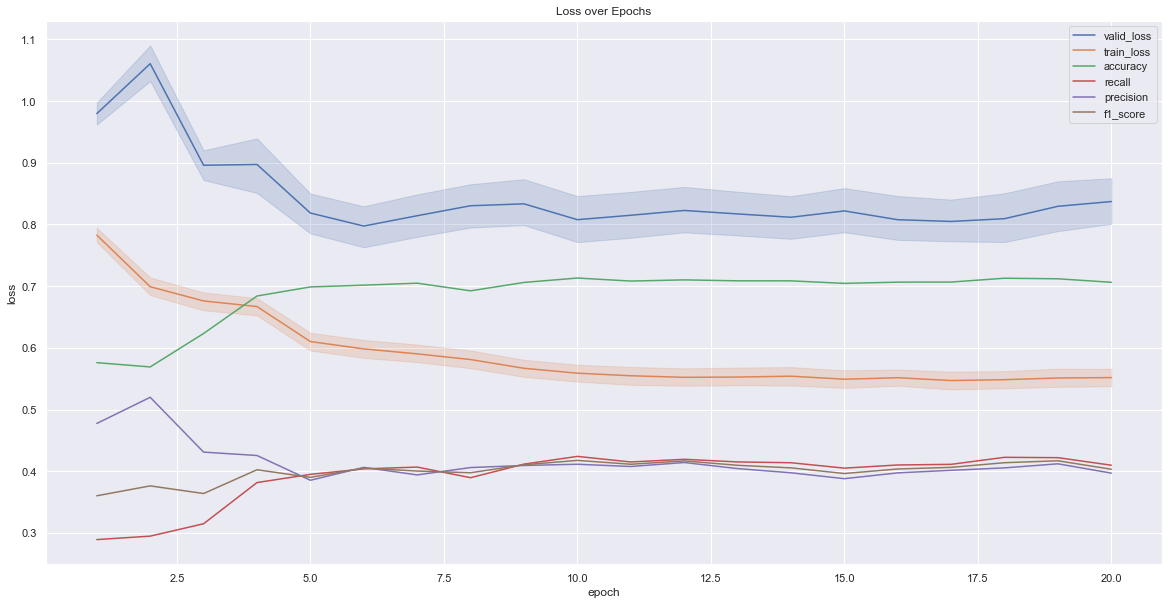

In [32]:
sns.set(rc={"figure.figsize":(20, 10)})
sns.lineplot(data=c_valid, x='epoch', y='loss', label='valid_loss').set(title='Loss over Epochs')
sns.lineplot(data=c_train, x='epoch', y='loss', label='train_loss').set(title='Loss over Epochs')
sns.lineplot(data=metric_df, x='epoch', y='accuracy', label='accuracy')
sns.lineplot(data=metric_df, x='epoch', y='recall', label='recall')
sns.lineplot(data=metric_df, x='epoch', y='precision', label='precision')
sns.lineplot(data=metric_df, x='epoch', y='f1_score', label='f1_score')
plt.show()

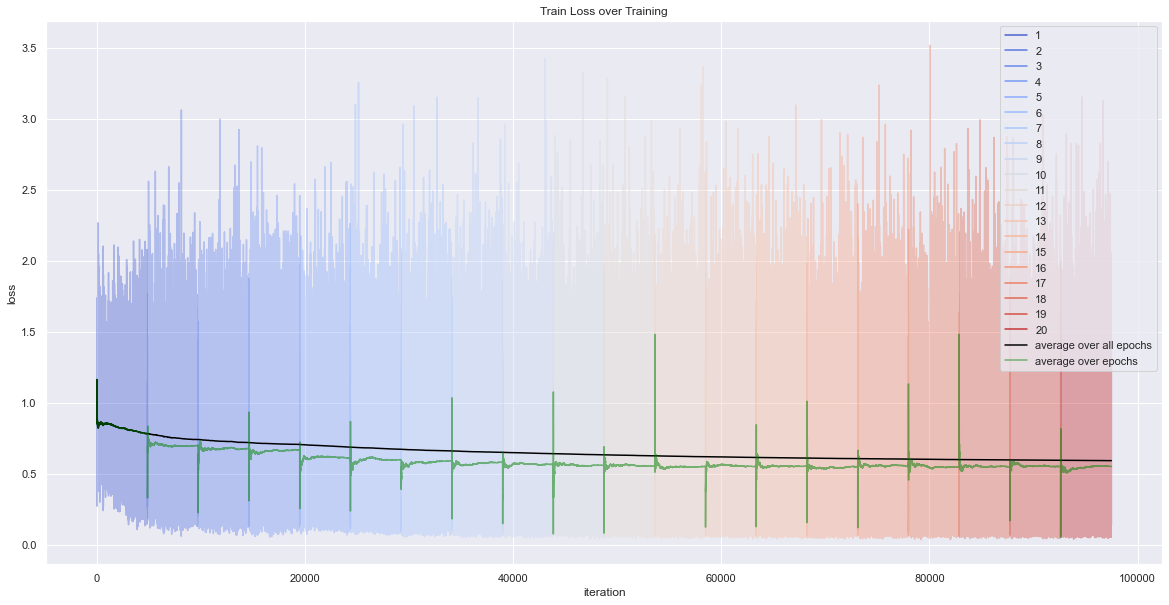

In [33]:
sns.set(rc={"figure.figsize":(20, 10)})
sns.lineplot(data=c_train, x='iteration', y='loss', 
             hue='epoch', alpha=0.4, palette=sns.color_palette('coolwarm', n_colors=obj['NB_EPOCHS'])).set(title='Train Loss over Training')
sns.lineplot(data=c_train, x='iteration', y='avg_loss', label='average over all epochs', color='black')
sns.lineplot(data=c_train, x='iteration', y='avg_loss_epoch', label='average over epochs', color='green', alpha=0.5)
plt.show()

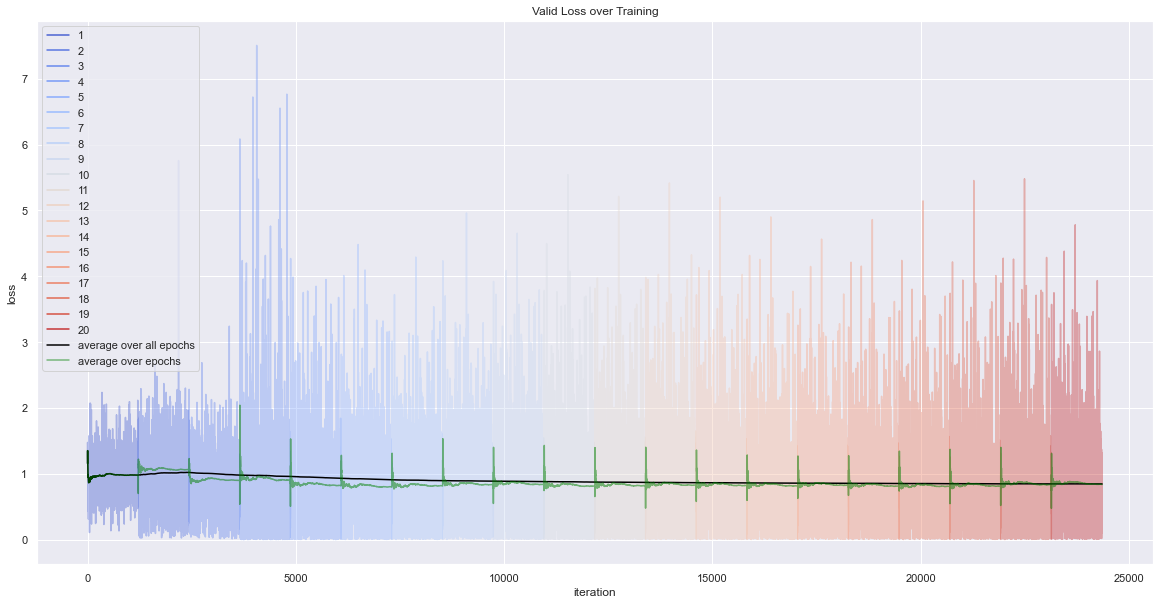

In [34]:
sns.set(rc={"figure.figsize":(20, 10)})
sns.lineplot(data=c_valid, x='iteration', y='loss', 
             hue='epoch', alpha=0.4, palette=sns.color_palette('coolwarm', n_colors=obj['NB_EPOCHS'])).set(title='Valid Loss over Training')
sns.lineplot(data=c_valid, x='iteration', y='avg_loss', label='average over all epochs', color='black')
sns.lineplot(data=c_valid, x='iteration', y='avg_loss_epoch', label='average over epochs', color='green', alpha=0.5)
plt.show()